In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Set hyperparameters

In [2]:
# output directory
output_dir = 'model_output/conv'

# training
epochs = 4
batch_size = 128

# vector space embedding
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer
n_conv = 256 # number of neurons in a filter
k_conv = 3 # kernel length
# this means tripplet of word "vectors" (or word "embeddings"), not three words.

# dense layer
n_dense = 256
dropout = 0.2

### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)                                                       

### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)

### Design neural network

In [5]:
model = Sequential()

# first hidden layer
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

# second hidden layer
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

# third hidden layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# output layer
model.add(Dense(1, activation='sigmoid'))

2024-03-03 17:17:59.942104: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-03 17:17:59.942123: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-03-03 17:17:59.942127: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-03-03 17:17:59.942153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-03 17:17:59.942166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           3200000   
                                                                 
 spatial_dropout1d (Spatial  (None, 400, 64)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 398, 256)          49408     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train

In [8]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4


2024-03-03 17:18:00.401909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 15s 71ms/step - loss: 0.4753 - accuracy: 0.7494 - val_loss: 0.3466 - val_accuracy: 0.8488
Epoch 2/4
  2/196 [..............................] - ETA: 12s - loss: 0.2627 - accuracy: 0.8984

/Users/jaejin/mambaforge/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 15s 74ms/step - loss: 0.2444 - accuracy: 0.9017 - val_loss: 0.3419 - val_accuracy: 0.8530
Epoch 3/4
196/196 [==============================] - 15s 78ms/step - loss: 0.1463 - accuracy: 0.9460 - val_loss: 0.3436 - val_accuracy: 0.8626
Epoch 4/4
196/196 [==============================] - 14s 74ms/step - loss: 0.0707 - accuracy: 0.9780 - val_loss: 0.3011 - val_accuracy: 0.8941


### Evaluate

In [14]:
model.load_weights(output_dir+"/weights.04.hdf5")

In [15]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 2s 2ms/step


In [16]:
y_hat.shape

(25000, 1)

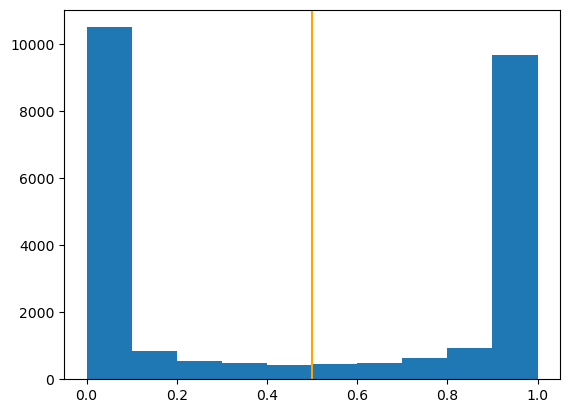

In [17]:
plt.hist(y_hat)
# plt.axvline(x=0.5, color='orange')
_ = plt.axvline(x=0.5, color='orange')

In [18]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat) * 100.0)

'95.96'